In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib import colors,cm
from scipy import stats
import dispersion_utils as utils
from matplotlib.animation import FuncAnimation
from datetime import timedelta

In [2]:
bins = np.arange(0,106,5)
bin_centers = (bins[1:] + bins[:-1]) / 2
len(bin_centers)

21

In [3]:
def get_sep_array(ds1, ds2, p_total, t_days):
    sep_array_1_2 = np.empty((p_total, t_days))
    sep_array_1_2[:] = np.nan
    for time_step in range(t_days):
        sep_array_1_2[:, time_step] = utils.distance(ds1['lon'][:, time_step], ds1['lat'][:, time_step], ds2['lon'][:, time_step], ds2['lat'][:, time_step])
    return sep_array_1_2

In [4]:
home_folder = "/nethome/manra003/analysis/dispersion/simulations/"
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
threshold_dist = 100    # km-  mesoscale

type1, type2= '3D','DVM'
p_total = 58027
t_days=100

all_sep_array = np.empty((p_total, t_days,len(months)))
all_CDFs = np.zeros((len(months),len(bin_centers)))

#Get monthly CDF from 100 days simulation.
for index, month in enumerate(months):
    ds1 = xr.open_zarr(home_folder + type1 + "/BenguelaUpwR_noneres_{0}2017_1z_100days.zarr".format(month))
    ds2 = xr.open_zarr(home_folder + type2 + "/BenguelaUpwR_noneres_{0}2017_1z_100days.zarr".format(month))

    # assert files are similar
    assert len(ds1.trajectory) == len(ds2.trajectory)
    assert len(ds1.obs) == len(ds2.obs)

    all_sep_array[:,:,index] = get_sep_array(ds1, ds2, p_total, t_days)
    all_CDFs[index,:],_ = utils.get_diff_CDF_PDF(all_sep_array[:,:,index], threshold_dist, bins)


DescribeResult(nobs=58027, minmax=(4.0, 104.0), mean=27.31828286831992, variance=357.30177220047904, skewness=2.2626406126121044, kurtosis=5.730101566994604)
DescribeResult(nobs=58027, minmax=(5.0, 104.0), mean=31.857376738414874, variance=439.03222089903016, skewness=1.8769787672175602, kurtosis=3.502895968575217)
DescribeResult(nobs=58027, minmax=(3.0, 104.0), mean=35.522722181053645, variance=557.3393787406384, skewness=1.6046949386186433, kurtosis=1.934946477734064)
DescribeResult(nobs=58027, minmax=(5.0, 104.0), mean=46.26205042480225, variance=806.4096312211846, skewness=0.8746498600486816, kurtosis=-0.4316373551392778)
DescribeResult(nobs=58027, minmax=(5.0, 104.0), mean=54.592827476864215, variance=884.8200588494102, skewness=0.5022790366978087, kurtosis=-1.0598553039617737)
DescribeResult(nobs=58027, minmax=(4.0, 104.0), mean=58.740120978165336, variance=850.2028922267731, skewness=0.3209574102199877, kurtosis=-1.1944982408315736)
DescribeResult(nobs=58027, minmax=(5.0, 104.0)

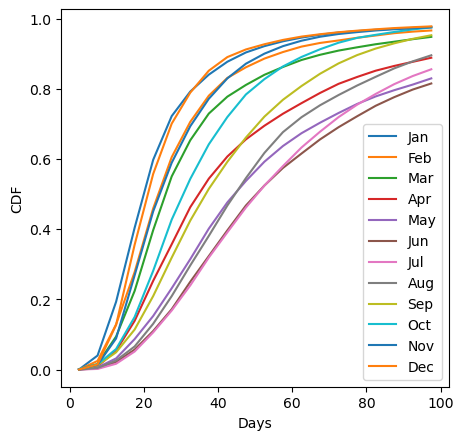

In [5]:
fig = plt.figure(figsize=(5,5), dpi=100)
for index, month in enumerate(months):
    plt.plot(bin_centers[:-1], all_CDFs[index,:-1], label=month)

plt.xlabel("Days")
plt.ylabel("CDF")
plt.legend()

In [6]:
def plot_mean_std(ind,l):
    mean=np.mean(all_CDFs[ind,:],axis=0)
    std=np.nanstd(all_CDFs[ind,:],axis=0)
    plt.plot(bin_centers[:-1], mean[:-1], label=l)
    plt.fill_between(bin_centers[:-1], mean[:-1] - std[:-1], mean[:-1] + std[:-1], alpha=0.2)

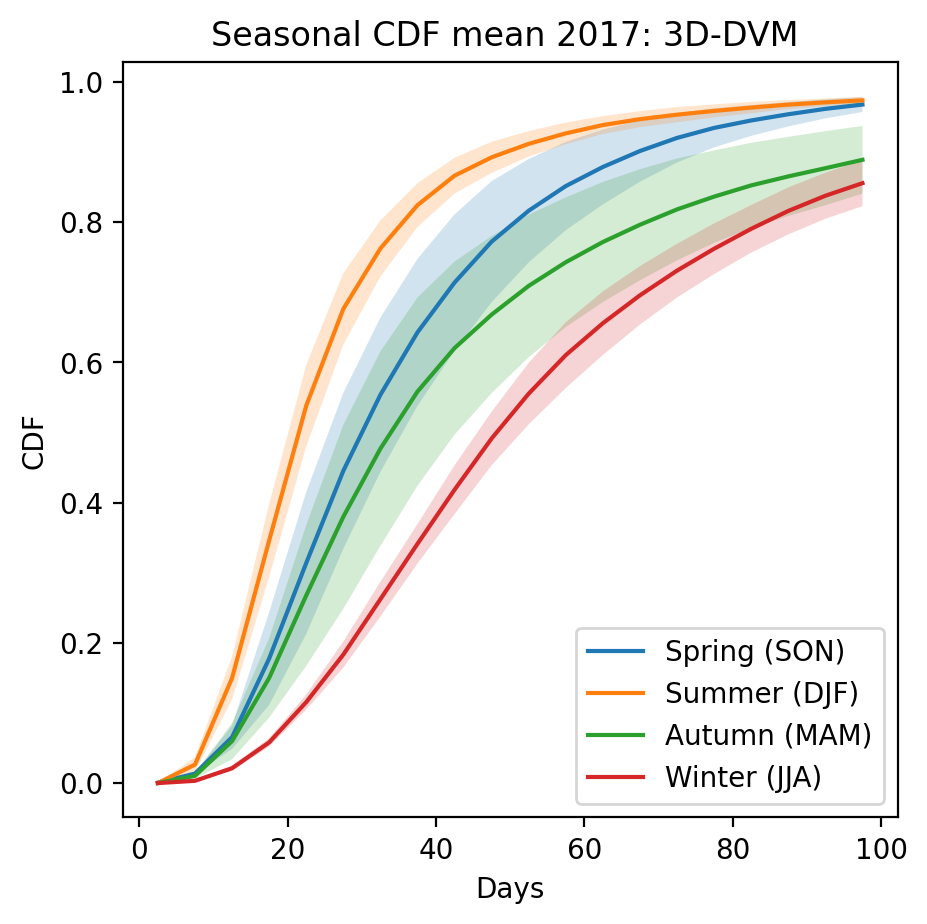

In [7]:
spring_ind = [8,9,10]
summer_ind = [11,0,1]
autumn_ind = [2,3,4]
winter_ind = [5,6,7]

fig = plt.figure(figsize=(5,5), dpi=200)
plt.title("Seasonal CDF mean 2017: 3D-DVM ")
plot_mean_std(spring_ind, "Spring (SON)")
plot_mean_std(summer_ind, "Summer (DJF)")
plot_mean_std(autumn_ind, "Autumn (MAM)")
plot_mean_std(winter_ind, "Winter (JJA)")

plt.xlabel("Days")
plt.ylabel("CDF")
plt.legend()


<h2> Plots of dispersion time for threshold distance

In [8]:
model_mask_file = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values[:,:,:,:]

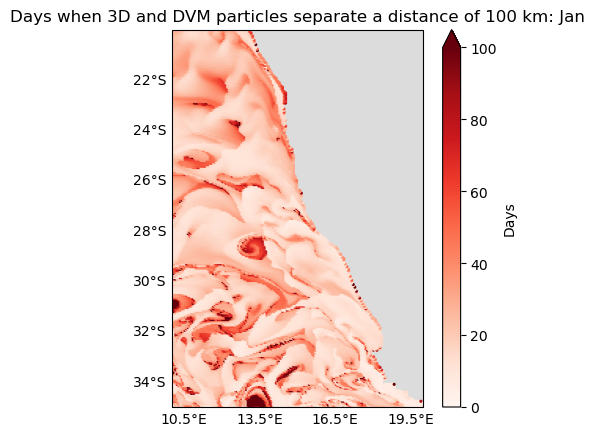

In [9]:
id = 0

custom_size=10
fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(10, 20)
ax.set_ylim(-35, -20)
# ax.set_xlim(12,16)
# ax.set_ylim(-29,-25)
plt.title("Days when 3D and DVM particles separate a distance of {0} km: {1}".format(threshold_dist, months[id]))

im=ax.scatter(ds1['lon'][:, 0], ds1['lat'][:, 0], c= utils.threshold_days(all_sep_array[:,:,id], threshold_dist), s=1.5, cmap='Reds', vmin=0, vmax=100)
cbar=fig.colorbar(im, ax=ax, label='Days', extend='max')

plt.show()

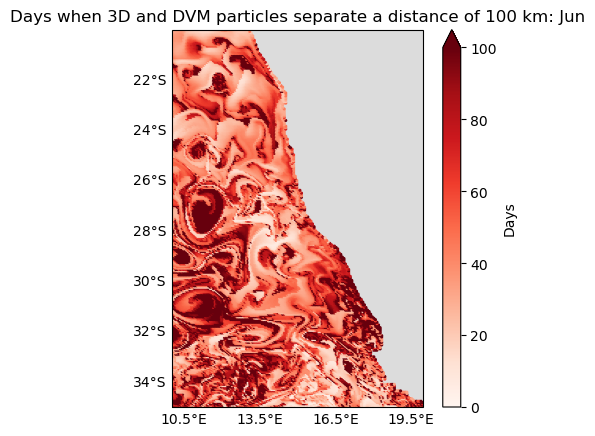

In [10]:
id = 5

custom_size=10
fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(10, 20)
ax.set_ylim(-35, -20)
# ax.set_xlim(12,16)
# ax.set_ylim(-29,-25)
plt.title("Days when 3D and DVM particles separate a distance of {0} km: {1}".format(threshold_dist, months[id]))

im=ax.scatter(ds1['lon'][:, 0], ds1['lat'][:, 0], c= utils.threshold_days(all_sep_array[:,:,id], threshold_dist), s=1.5, cmap='Reds', vmin=0, vmax=100)
cbar=fig.colorbar(im, ax=ax, label='Days', extend='max')

plt.show()